In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from torchsummary import summary
from sklearn.model_selection import train_test_split

In [7]:
# Hyperparameters
numOfConvLayers = 4
numOfKernels = 12
numOfNeurons = 12
learningRate = 0.1
batchSize = 48
numOfEpochs = 50
kernelSize = 3
activation = F.relu       
optimizer_func = torch.optim.SGD
loss_fnc = nn.CrossEntropyLoss()
batchNorm = False
numOfFCLayers = 2
testSize = 0.2
valSize = 0.2
seed = 42

In [8]:
# Helpers
def plot_full_data(trainAccuracies, trainLosses, validAccuracies, validLosses):
  # Accuracy plot
  pyplot.plot(trainAccuracies, label='training')
  pyplot.plot(validAccuracies, label='validation')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('# of epochs')
  pyplot.title('Training accuracy vs. # of epochs of the full dataset')
  pyplot.show()

  # Loss plot
  pyplot.plot(trainLosses, label='traning')
  pyplot.plot(validLosses, label='validation')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('# of epochs')
  pyplot.title('Loss vs. # of epochs of the full dataset')
  pyplot.show()

# Train Overfit Model
def overfit_training (data_loader, model, optimizer):
  trainAccuracies = []
  trainLosses = []
  start_time = time.time()
  model.train()
  for epoch in range(numOfEpochs):
    totalLoss = 0
    totalCorrect = 0
    for i, (inputs, labels) in enumerate(data_loader):
      optimizer.zero_grad() 
      outputs = model(inputs)                                  # Get outputs
      oneh_labels = oneh_classes[labels]                       # Get one hot labels
      if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
        loss = loss_fnc(input=outputs, target=labels) 
      else: 
        loss = loss_fnc(input=outputs, target=oneh_labels)  
      loss.backward()                                          # Compute loss gradients
      optimizer.step()                                         # Adjust weights 
      totalCorrect += numOfCorrectPredictions(outputs, labels)
      totalLoss += loss.item()
    
      del outputs
      del loss
    # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
    # my loss at each epoch is the average loss over the entire epoch
    avg_accuracy = float(totalCorrect) / len(data_loader.dataset) 
    avg_loss = totalLoss/len(data_loader)
    print(epoch, avg_loss, avg_accuracy)
    trainAccuracies += [avg_accuracy]  
    trainLosses += [avg_loss]
  print("total time: ")
  print(time.time()-start_time)
  return trainAccuracies, trainLosses

def numOfCorrectPredictions(Y, L):
  result = Y.argmax(1)      # Get the maximum value in each output and compare it to its label
  return (result == L).sum()

def evaluate(model, data_loader, batchNorm):   # used on validation and test set
  total_corr = 0
  totalLoss = 0
  if batchNorm:
    model.eval()
  else:
    model.train()
  for i, (inputs, labels) in enumerate(data_loader):
    oneh_labels = oneh_classes[labels]
    outputs = model(inputs)
    if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
      loss = loss_fnc(input=outputs, target=labels) 
    else: 
      loss = loss_fnc(input=outputs, target=oneh_labels) 
    total_corr += numOfCorrectPredictions(outputs, labels) 
    totalLoss += loss.item()
  accuracy = float(total_corr)/len(data_loader.dataset)
  loss = totalLoss/len(data_loader)
  return (loss, accuracy)

In [9]:
# Custom Horizontal Pad Pipeline 
class SquarePad:
  def __call__(self, image):
    w = image.size[0]  
    maxw = 130            #pad to 130
    hp = (maxw - w) // 2
    remainder = (maxw - w) % 2
    padding = (hp, 0, hp+remainder, 0)
    return transforms.functional.pad(image, padding, 0, 'constant')

In [10]:
# Input overfit, train, val, test dataset 
# Load un-normalized data to compute mean and standard deviation.
image_size = (100, 65) # size of the input image we want to pass into the model (100 height is standard already)
                       # In our dataset, (100, 65) is size of the smallest image,
                       # (100, 130) is size of the biggest image.

ResizeMethods = {"pad": [SquarePad()], 
                 "crop": [transforms.CenterCrop(image_size)], 
                 "scale": [transforms.Resize(image_size)]
                 }
resizeMethod = "crop"

# padding/cropping pipeline for unnormalized dataset
data_pipe = transforms.Compose(ResizeMethods[resizeMethod] +
    [transforms.ToTensor()])

path = 'data'
dataset_raw = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=data_pipe)
loader = DataLoader(dataset_raw, batch_size=len(dataset_raw))
data = next(iter(loader))
mean = torch.mean(data[0], (0,2,3))
std = torch.std(data[0], (0,2,3))
print(mean, std)

# padding/cropping pipeline for normalized datasets
data_pipeline_normal_reg = transforms.Compose(ResizeMethods[resizeMethod] + 
    [transforms.ToTensor(), transforms.Normalize(mean, std)])

# Normalized dataset
dataset = torchvision.datasets.ImageFolder(\
            root=path, \
            transform=data_pipeline_normal_reg)


train_set, test_set = train_test_split(dataset, test_size=testSize, random_state=seed)   # split test
train_set, val_set = train_test_split(train_set, test_size=valSize/(1-testSize), random_state=seed)   # split train to train and val

train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=True)

# overfit_loader = DataLoader(overfit_set, batch_size=batchSize, shuffle=True)

[[[0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.74509805 ... 0.7411765  0.4274581  0.4274581 ]
  ...
  [0.4274581  0.4274581  0.         ... 0.         0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]]

 [[0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.74509805 ... 0.7411765  0.4274581  0.4274581 ]
  ...
  [0.4274581  0.4274581  0.         ... 0.         0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]]

 [[0.4274581  0.4274581  0.4274581  ... 0.4274581  0.4274581  0.4274581 ]
  [0.4274581  0.427458

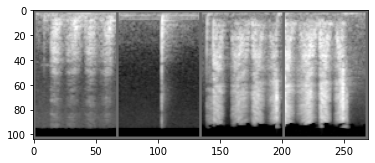

W Scratch Fingernail Tap W Scratch W Scratch
The one-hot classes are: 
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [15]:
# Check the ground truth of the images
def imshow(img):
  img[0] = img[0] * std[0] + mean[0]     # De-normalize
  img[1] = img[1] * std[1] + mean[1]     # De-normalize
  img[2] = img[2] * std[2] + mean[2]     # De-normalize
  npimg = img.numpy()
  print(npimg)
  pyplot.imshow(np.transpose(npimg, (1, 2, 0)))
  pyplot.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:4]))
classes = ['Circle Scratch', 'Fingernail Tap', 'Fingertip Tap', 'Silence', 'Vertical Scratch', 'W Scratch'] 
print(' '.join('%5s' % classes[labels[j]] for j in range(0,4))) 

# One-hot encode the classes
oneh_encoder = OneHotEncoder()
oneh_classes = torch.Tensor(oneh_encoder.fit_transform(np.asarray(classes).reshape(-1, 1)).toarray())
print("The one-hot classes are: ")
print (oneh_classes)

In [12]:
class CNN(nn.Module):
  def __init__(self, input_dims, numOfKernels, numOfNeurons, kernelSize, numOfConvLayers, batchNorm):
    super(CNN, self).__init__()         
    self.numOfKernels = numOfKernels
    self.batchNorm = batchNorm
    self.numOfConvLayers = numOfConvLayers

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3,numOfKernels, kernelSize)
    self.conv2 = nn.Conv2d(numOfKernels,numOfKernels, kernelSize)
    self.conv_BN = nn.BatchNorm2d(numOfKernels)

    # Determine the output size after the convolutional layer
    fullLayerSize_x = input_dims[1]
    fullLayerSize_y = input_dims[0]
    for i in range (self.numOfConvLayers):
      fullLayerSize_x = (fullLayerSize_x-kernelSize+1)//2
      fullLayerSize_y = (fullLayerSize_y-kernelSize+1)//2

    # Error check the output size
    if fullLayerSize_x <= 0 or fullLayerSize_y <= 0:
      raise Exception("Too many convolutional layer for the input size, please decrease numOfConvLayers.")

    # Fully connected layers
    self.fc1 = nn.Linear(numOfKernels*fullLayerSize_x*fullLayerSize_y, numOfNeurons)
    self.fc1_BN = nn.BatchNorm1d(numOfNeurons)
    self.pool = nn.MaxPool2d(2,2)
    self.fc2 = nn.Linear(numOfNeurons, 6)
    self.fc2_BN = nn.BatchNorm1d(6)

  def forward(self, x):
    if self.batchNorm == True:
      x = self.pool(activation(self.conv_BN(self.conv1(x))))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv_BN(self.conv2(x))))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1_BN(self.fc1(x)))
      x = self.fc2_BN(self.fc2(x))
    else: 
      x = self.pool(activation(self.conv1(x)))
      for i in range (self.numOfConvLayers - 1):
        x = self.pool(activation(self.conv2(x)))
      x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
      x = activation(self.fc1(x))
      x = self.fc2(x)
    return x

In [17]:
TR_seed = 6
TR_batch = 48
TR_kernels = 12
TR_LR = 0.1
NUM_NEURONS = 100
EPOCHS = 50

# create train, val, test, and overfit dataset
train_set, test_set = train_test_split(dataset, test_size=testSize, random_state=TR_seed)   # split test
train_set, val_set = train_test_split(train_set, test_size=valSize/(1-testSize), random_state=TR_seed)   # split train to train and val

train_loader = DataLoader(train_set, batch_size=TR_batch, shuffle=True)
val_loader = DataLoader(val_set, batch_size=TR_batch, shuffle=True)
test_loader = DataLoader(test_set, batch_size=TR_batch, shuffle=True)

# Training Loop
def training(train_loader, val_loader, test_loader, model, optimizer):
    trainAccuracies = []
    validAccuracies = []
    trainLosses = []
    validLosses = []
    start_time = time.time()
    model.train()
    for epoch in range(EPOCHS):
        totalCorrect = 0
        totalLoss = 0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad() 
            print(inputs.shape)
            return
            outputs = model(inputs)                                  # Get outputs
            oneh_labels = oneh_classes[labels]                       # Get one hot labels
            if str(loss_fnc) == "CrossEntropyLoss()":                # CrossEntropyLoss does not accept one-hot labels
                loss = loss_fnc(input=outputs, target=labels) 
            else: 
                loss = loss_fnc(input=outputs, target=oneh_labels) 
            loss.backward()                                          # Compute loss gradients
            optimizer.step()                                         # Adjust weights 
            totalCorrect += numOfCorrectPredictions(outputs, labels)
            totalLoss += loss.item()

            del outputs
        # For every epoch, compute the training accuracy and loss
        # Here, my accuracy at each epoch is the average accuracy across the entire epoch;
        # my loss at each epoch is the average loss over the entire epoch
        avg_train_accuracy = float(totalCorrect) / len(train_loader.dataset)
        avg_train_loss = totalLoss/len(train_loader)

        # For every epoch, get accuracy, and loss of the validation data
        (valid_loss, valid_accuracy) = evaluate(model, val_loader, batchNorm)
        trainAccuracies += [avg_train_accuracy]  
        trainLosses += [avg_train_loss]
        validAccuracies += [valid_accuracy]  
        validLosses += [valid_loss]

    print("total time: ")     # print total time 
    print(time.time()-start_time)
    (test_loss, test_accuracy) = evaluate(model, test_loader, batchNorm)    # evaluate the test data
    print("the test accuracy and loss after CNN model is ", test_accuracy, test_loss)

    return trainAccuracies, trainLosses, validAccuracies, validLosses, test_accuracy, test_loss

torch.manual_seed(TR_seed)
model = CNN(input_dims=image_size, numOfKernels=TR_kernels, numOfNeurons=NUM_NEURONS, kernelSize=3, numOfConvLayers=2, batchNorm=True)    # Load model 
optimizer = optimizer_func(model.parameters(), lr=TR_LR)
trainacc, trainloss, valacc, valloss, testacc, testloss = training(train_loader, val_loader, test_loader, model, optimizer)

# Generate Plots


# Save Model
torch.save(model, 'models/croppped_best.pt')

torch.Size([48, 3, 100, 65])


TypeError: cannot unpack non-iterable NoneType object